In [192]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from functools import reduce, lru_cache
import datetime
import pickle

In [241]:
@lru_cache(maxsize=None)
def unary(x, C):
    nearest_x = int(np.round(x))
    return(np.r_[np.ones(nearest_x), np.zeros(C-nearest_x)])

@lru_cache(maxsize=None)
def lsh_hash(point, C):
    point = np.array(point)
    res = np.concatenate(list(map(lambda x: unary(x, C), point)))
    return(res)

@lru_cache(maxsize=None)
def get_points_in_cluster(idx, clusters, data):
    clusters = np.array(clusters)
    data = pickle.loads(data)
    point_cluster = clusters[idx]
    same_cluster_points_idx = np.where(clusters == point_cluster)[0]
    same_cluster_points = set(map(tuple, data[same_cluster_points_idx, :]))
    return same_cluster_points

def get_point_indices(data, points):
    indices = np.where((data == points[:,None]).all(-1))[1]
    return indices

def data_extend(data, k):
    r, c = data.shape
    data_extend = (reduce(lambda x, y: np.vstack((x, y)), map(lambda x: data, range(k))) +
                  np.random.randn(r*c*k).reshape(r*k, c).round(1))
    return(data_extend)

def hac(k, data):
    n = data.shape[0]
    
    # start with each point in its own cluster
    clusters = np.arange(n)
    unique_clusters = len(np.unique(clusters))
    
    while unique_clusters > k:
        min_distances = np.zeros(n)
        min_points = np.zeros(n).astype('int')

        # for each point, find min distance to point not in cluster
        for i in range(n):
            point = data[i,]
            point_cluster = clusters[i]
            distances = np.linalg.norm(point - data, axis = 1)
            diff_cluster_points = np.where(clusters != point_cluster)[0]

            min_points[i] = diff_cluster_points[np.argmin(distances[diff_cluster_points])]
            min_distances[i] = distances[min_points[i]]

        # merge clusters of the two closest points
        point1_idx = np.argmin(min_distances)
        point1 = data[point1_idx,]
        point2_idx = min_points[point1_idx]
        point2 = data[point2_idx,]

        point2_cluster = clusters[point2_idx]
        clusters[np.where(clusters == point2_cluster)[0]] = clusters[point1_idx]

        # update number of clusters
        unique_clusters = len(np.unique(clusters))
    
    return clusters

In [194]:
def build_hash_tables(C, d, l, k, data, clusters):
    vals = np.arange(C*d)
    n = data.shape[0]
    hash_tables = defaultdict(set)
    hash_tables_reversed = defaultdict(set)

    for i in range(l): # use multiprocessing to speed this up? separate thread for each hash function?
        I = np.random.choice(vals, k, replace = False) # figure out if replace = True or False

        for j in range(n):
            # for every point, generate hashed point and sample k bits
            p = data[j]
            hashed_point = lsh_hash(tuple(p), C)[I]
            
            # check if any other points in p's cluster are already in this hash table
            # and only add point to hash table if no other points from its cluster are there
            bucket = hash_tables[tuple(hashed_point)]
            cluster_points = get_points_in_cluster(j, tuple(clusters), pickle.dumps(data))

            if not cluster_points.intersection(bucket):
                hash_tables[tuple(hashed_point)].add(tuple(p))
                hash_tables_reversed[tuple(p)].add(tuple(hashed_point))
    
    return hash_tables, hash_tables_reversed

In [225]:
iris = datasets.load_iris().data * 10


# iris = datasets.load_iris().data
# iris = data_extend(iris, 10) * 10
# iris += np.abs(np.min(iris))

In [226]:
iris.shape

(150, 4)

In [232]:
def LSHLink(data, A, l, k, C = None, cutoff = 1, dendrogram = False):
    # set default value for C if none is provided
    if not C:
        C = int(np.ceil(np.max(data))) + 1
    
    if dendrogram and cutoff != 1:
        raise Exception('Dendrogram requires a full hierarchy; set cutoff to 1')
    
    # initializations
    n, d = data.shape
    clusters = np.arange(n)
    unique_clusters = len(np.unique(clusters))
    num = n - 1
    Z = np.zeros((n - 1, 4))
    count = 0 # REMOVE THIS
#     start = datetime.datetime.now() # REMOVE THIS
    
    # calculate r depending on n, either:
    # 1. min dist from a random sample of sqrt(n) points
    # 2. formula below
    np.random.seed(12) # REMOVE SEED? MAKE SURE CODE STILL WORKS FOR R VALUE
    n_samp = int(np.ceil(np.sqrt(n)))
    samples = data[np.random.choice(n, size = n_samp, replace = False), :]
    
    if n < 500:
        r = np.min(pdist(samples, 'euclidean'))
    else:
        r = (d * C * np.sqrt(d)) / (2 * (k + d))
    
    np.random.seed(6) # REMOVE SEED?

    while unique_clusters > cutoff: # REMOVE COUNT LIMIT
        # STEP 1: Generation of hash tables
        hash_tables, hash_tables_reversed = build_hash_tables(C, d, l, k, data, clusters)

        # STEP 2: Nearest neighbor search for p
        for i in range(n):
            # get all of those hash tables that contain point p
            p = data[i]
            p_hashes = hash_tables_reversed[tuple(p)]

            # only proceed if p is in at least one hash table
            if hash_tables_reversed[tuple(p)]:

                # find all "similar points" to p: points that share at least one
                # hash table with p, and are not in the same cluster as p
                similar_points = reduce(
                    lambda x, y: x.union(y),
                    map(lambda x: hash_tables[x], p_hashes)
                    ).difference(get_points_in_cluster(i, tuple(clusters), pickle.dumps(data)))
                similar_points = np.array(list(similar_points))

                # STEP 3: Connect pairs of clusters within certain distance of p
                # only proceed if p has any similar points
                if similar_points.size:

                    # find similar points q s.t. dist(p, q) < r
                    # the clusters containing these points will be merged with p's cluster
                    points_to_merge = similar_points[
                        np.where(np.linalg.norm(p - similar_points, axis = 1) < r)[0]
                    ]

                    # only proceed if p has similar points within distance r
                    if points_to_merge.size:
                        # identify which clusters contain points_to_merge
                        point_indices = get_point_indices(data, points_to_merge)
                        clusters_to_merge = list(np.unique(clusters[point_indices]))
                        clusters_to_merge.append(clusters[i])
                        
                        # update cluster labels
                        # if dendrogram = False, we can use a simpler method
                        if not dendrogram:
                            clusters[np.where(np.in1d(clusters, clusters_to_merge))[0]] = clusters[i]
                        
                        else:
                            for j in range(len(clusters_to_merge) - 1):
                                clusterA = clusters_to_merge[j]
                                clusterB = clusters_to_merge[j+1]
                                num += 1
                                clusters[np.where(np.in1d(clusters, [clusterA, clusterB]))[0]] = num

                                Z[num - n, :] = np.array([clusterA, clusterB, r,
                                                            len(np.where(np.in1d(clusters, num))[0])])
                                clusters_to_merge[j:j+2] = 2 * [num]

        # STEP 4: update parameters and continue until unique_clusters == cutoff
        unique_clusters = len(np.unique(clusters))
        count += 1

        #increase r and decrease k
        r *= A
        k = int(np.round((d * C * np.sqrt(d)) / (2 * r)))

#         print(unique_clusters, r, k)
#         print(clusters)
#         print('\n')

#     end = datetime.datetime.now() # REMOVE THIS
#     print(end-start) # REMOVE THIS
    
    if not dendrogram:
        return clusters
    
    else:
        return clusters, Z

In [213]:
%timeit -r1 linkage(iris, method="single")

18.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [214]:
%timeit -r1 hac(1, iris)

3min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [218]:
%timeit -r1 LSHLink(iris, A = 1.4, l = 10, k = 100, dendrogram = False)

22.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [203]:
l = 10
k = 100
n, d = iris.shape
C = int(np.ceil(np.max(iris))) + 1
clusters = np.arange(n)

In [204]:
%timeit -r1 build_hash_tables(C, d, l, k, iris, clusters) # generation of hash tables scales linearly

521 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [144]:
%timeit -r1 build_hash_tables(C, d, l, k, iris, clusters) # generation of hash tables scales linearly

728 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [238]:
clusters, Z = LSHLink(iris, A = 1.4, l = 10, k = 100, dendrogram = True)

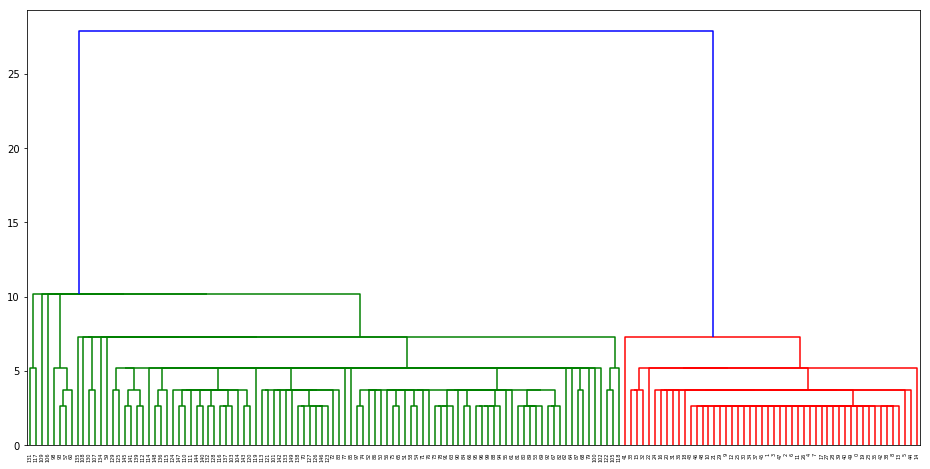

In [239]:
dendrogram(Z, color_threshold = 18)
plt.gcf().set_size_inches(16, 8)
plt.show();

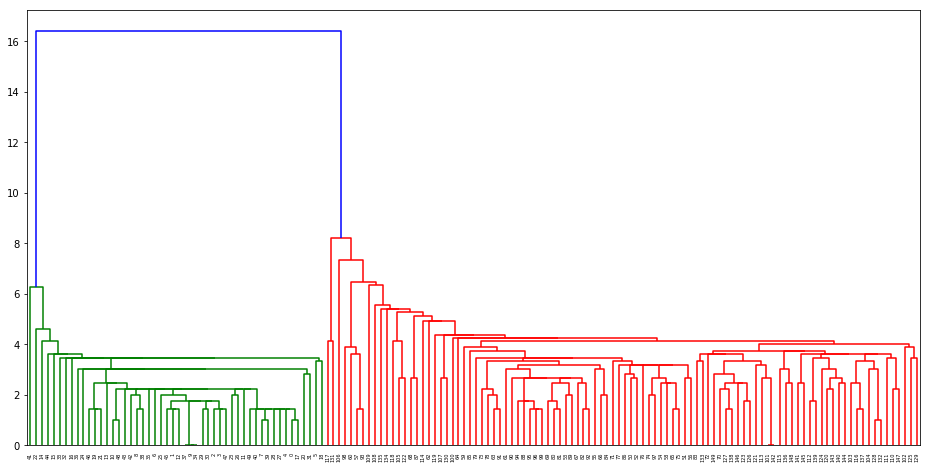

In [240]:
z = linkage(iris, method="single")
z

dendrogram(z)
plt.gcf().set_size_inches(16, 8)
plt.show();